<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/CT_acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 6: CT Acquisition

## CT Acquisition ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/img/gvxr_logo.png?raw=1)

## Authors: Iwan Mitchell

(version 1.0, 13 Oct 2022)

## Aims of this Session
- Learn how to perform a simulated CT Acquisition
- Use reconstructed data to see how simulation parameters affect quality
- Discover the effects of polychromatic beams on results
- Compare simulated samples to real data

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
#  !conda install -c anaconda cudatoolkit==9.2

In [3]:
# !mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil=22.0.0 numpy==1.20.3 astra-toolbox  --quiet
!mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil numpy astra-toolbox tigre --quiet


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Encountered problems while solving:
  - package tigre-2.2-np122py38_38 requires cudatoolkit 9.2.*, but none of the

In [3]:
!pip3 install --upgrade gvxr xpecgen #k3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os


# The directory does not exist
if not os.path.exists("input_data"):
    
    # Create the directory
    os.mkdir("input_data")

# The directory does not exist
if not os.path.exists("input_data/phantoms"):
    
    # Create the directory
    os.mkdir("input_data/phantoms")

# # The directory does not exist
# if not os.path.exists("input_data/phantoms/spheres"):
    
#     # Create the directory
#     os.mkdir("input_data/phantoms/spheres")

files = ["utilities.py",
         "input_data/phantoms/doga-plate.stl"
        ]

for fname in files:
    if True: #not os.path.exists(fname):
        import urllib.request
        url = "https://github.com/effepivi/gvxr-tutorials/raw/main/" + fname
        print("Download the file (%s) from %s" % (fname, url))
        urllib.request.urlretrieve(url, fname)

Download the file (utilities.py) from https://github.com/effepivi/gvxr-tutorials/raw/main/utilities.py
Download the file (input_data/phantoms/doga-plate.stl) from https://github.com/effepivi/gvxr-tutorials/raw/main/input_data/phantoms/doga-plate.stl


In [5]:
import k3d
from gvxrPython3 import gvxr
from gvxrPython3.utils import visualise
import numpy as np
import matplotlib.pyplot as plt
from utilities import recon_parallel, recon_widget, recon_cone
import cil
import ipywidgets as widgets
from skimage.util import compare_images
import tifffile as tf
import matplotlib.cm as cm

spekpy is not install, you won't be able to load a beam spectrum using spekpy


# Performing a CT Acquisition
CT scanners are able to create 3D slices through an object by using multiple X-ray images (also known as projections, or radiographs) taken at various angles around a sample. The full details and terminology of how this reconstruction method works will be covered in tomorrow's training with CIL, for now we will treat it as a black-box function. The quality of projections directly impact the details in the final result, in this session we will take a look at what can effect our scan. *Some of the impacts on getting good scans are not obvious!*

## Two Case Studies

To better demonstrate what is going on, we will show two examples based on real-world use cases.

One use case is using an aluminium plate in a standard industrial/Lab CT machine, where we want results to measure hole diameters cut into the plate.

The second case study is looking at a parallel synchrotron beam to scan tungsten fibers, and seeing how non-obvious beam properties can have a large impact on results.

---

# Aluminium Plate Case Study

In This case study you will learn:
- How to simulate a CT scan with gvxr using python
- How detector properties affect result quality

The aluminium plate phantom is a 50mmx50mm plate with cylindrical holes cut into the surface. The holes are in a total of 5 different sizes and do not cut through the entire plate. We would like to measure the diameters of these holes using a lab CT machine, but first we want to know if results are possible in the best-case scenario, hence using simulations.

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

In [7]:
# Load stl and display
plot = k3d.plot()
with open("input_data/phantoms/doga-plate.stl", "rb") as model:
    plot += k3d.stl(model.read(),color=0xfdea4f)
plot.display()

Output()

## Task 1: Setup

With your new-found knowledge of gvxr, setup the experiment environment as follows:

1. Fixed detector 1m away from the source with a size of 216mmx36mm with a pixel pitch of 240um
2. The detector's lsf has been measured and stored in `input_data/lsf.npy`, display and apply it to the detector
3. A tungsten tube source with the power at 10keV
4. The plate model `input_data/phantoms/doga-plate.stl` is in mm and should be made from aluminium, lying face-up and in focus.

Notes for compatibility with CIL:
- Ensure the detector's up vector is `[0, 0, 1]`
- The source position is `positive y`
- The detector position is `negative y`

In [6]:
print("Create an OpenGL context")

window_id = 0
opengl_major_version = 4
opengl_minor_version = 5

# gvxr.createOpenGLContext(window_id, opengl_major_version, opengl_minor_version);

# backend = "OPENGL"
# visible = True

# gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

visible = False
# gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

backend = "EGL"
# visible has no effect with EGL
gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

Create an OpenGL context


In [7]:
# Setup Detector
gvxr.setDetectorPosition(0, -0.2, 0, "m")
gvxr.setDetectorNumberOfPixels(1216, 200)
gvxr.setDetectorPixelSize(180, 180, "um")
gvxr.setDetectorUpVector(0, 0, 1)
# gvxr.setLSF()

# Setup Source
gvxr.setSourcePosition(0,0.8,0,"m")
gvxr.usePointSource()
# gvxr.setFocalSpot(0,0,20,0.02,"mm",3)
gvxr.addEnergyBinToSpectrum(10, "keV", 1)

# Setup Plate Model
gvxr.removePolygonMeshesFromSceneGraph()
gvxr.loadMeshFile("plate", "input_data/phantoms/doga-plate.stl", "mm")
gvxr.setElement("plate", "Al")

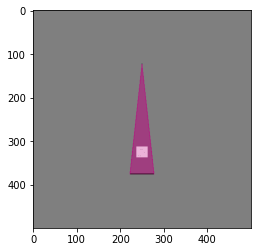

In [8]:
# Preview the environment
gvxr.displayScene()
plt.imshow(gvxr.takeScreenshot())

In [11]:
plot=visualise(use_log=True)
plot.display()

Output()

In [12]:
from google.colab import output
output.disable_custom_widget_manager()

## Task 2: Scanning
Now that the scene is setup, we'll take a look into reproducing a virtual scan of the plate, by taking x-ray images and rotating the sample with `gvxr.rotateScene()`

Complete the code snippets below by replacing `???` with the correct code. At the end, you'll have completed your own CT acquisition, which we'll use for reconstruction.
We want to rotate around the detector's up axis.

In [9]:
# Define the number of projections, along with the angle step
total_projections = 100
final_angle = 180
angle_step = final_angle / total_projections

In [10]:
# Pre-create our results array with the size of our detector
projections = np.ndarray((total_projections, 200, 1216))

# Rotate our object by angle_step for every projection, saving it to the
# results array.
for i in range(0, total_projections):
    # Save current angular projection
    projections[i] = gvxr.computeXRayImage()
    # Rotate models
    gvxr.rotateScene(angle_step,0,0,1)

In [11]:
# Don't forget, we need to use flatfield normalisation on the radiographs to get the correct attenuation values!
# Because our flatfield and darkfield are perfect, all we need to do is divide by the total energy
projections /= gvxr.getTotalEnergyWithDetectorResponse()

We have now taken a full radial scan of our target object. Using these projections we can reconstruct our data into tomographical slices, and see if it's possible to measure the size of our plate's circles.

There are two provided methods: `reconstruct_parallel` and `reconstruct_cone`. A more in-depth look into CIL will be in tomorrow's training. For now, treat these functions as blackboxes.

In [12]:
has_cil = True
try:
    from cil.framework import AcquisitionData, AcquisitionGeometry, ImageData
    from cil.processors import TransmissionAbsorptionConverter
    from cil.recon import FBP, FDK
    #from cil.plugins.astra.processors import FBP
    from cil.utilities.display import show_geometry
except:
    has_cil = False

print(has_cil)

True


In [17]:
 !mamba install -c anaconda cudatoolkit==9.2 --quiet


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Encountered problems while solving:
  - conflicting requests



In [16]:
!mamba install -c ccpi tigre  --quiet


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Encountered problems while solving:
  - package tigre-2.2-np122py38_38 requires cudatoolkit 9.2.*, but none of the

In [13]:
# Reconstruct the simulated projections with CIL.
recon = recon_cone(projections, 180/1000, final_angle,gvxr.getSourcePosition("mm"), gvxr.getDetectorPosition("mm"))
assert recon is not None

Has CIL: YES
Running FBP Reconstruction


AttributeError: ignored

In [ ]:
# Interactive simple data display
display(recon_widget(projections, recon))

## Task 3: Tweaking
🎉 Congratulations, you've done a virtual CT scan!

Now take a look at your results and see how well you did!

With our new CT setup, we can explore what our lab scanner can do. Take a go at the little questions below and see if you can answer them!

1. Does your plate clip the edge of your scanner?
    - How can you fix this without changing the detector's size?
2. Are the holes visible in the reconstruction?
    - Try changing the color range to increase the contrast.
    - Does changing the source power make your results better?
3. What other values can you change to get a higher quality scan with the lab setup?
    - Do more projections help?
    - What can't you change with the lab setup that will help the CT scan?
4. In your opinion, would this experiment be feasible on the lab setup?

---

# Titanium Fibre Case Study

In this case study you will learn:
- How to automate this simulation process with json2gvxr
- An easy way to compare real results with simulated results
- Show how 'almost' pure sources will change real results

Our sample is a Ti/SiC composite to be scanned at a synchrotron source. It is composed of an outer titanium-aluminium-vanadium alloy with nested silicon carbide fibres housing tungsten cores. A mockup using carbon cores has also been made. However, when scanning the tungsten-cored sample, it presents artifacts not seen in the carbon-core sample.

- We will take a look at how "almost pure" beam sources can effect scanning results with higher attenuating materials, and how these properties can be recreated with simulations.
- A faster method of representing experimental setups and running simulated 
scans will also be introduced.


| Sample in holder | Sample Under Microscope | 
| --- | --- |
| ![](https://github.com/effepivi/gvxr-tutorials/blob/img/sample-annotated.png?raw=1) | ![](https://github.com/effepivi/gvxr-tutorials/blob/img/sample-microscope.png?raw=1) |

![](https://github.com/effepivi/gvxr-tutorials/blob/img/CT_ref_annotated.png?raw=1)


## Task 1: Json2Gvxr

So far, you have been shown how to use gvxr command-by-command. This can be a
bit tedious when wanting a simple scanning setup. Gvxr provides utility methods
to make life easier...

`Json2gvxr` is a utility library to dynamically load and setup gvxr from a json file.
A json file is a simple formatted text file commonly used in many different languages.

Here is a snippet from `./JSON/notebook4-focal_spot.json` describing detector parameters:
```json
"Detector": {
    "Position": [0, 10, 0, "cm"],
    "UpVector": [0, 0, 1],
    "NumberOfPixels": [300, 320],
    "Spacing": [0.5, 0.5, "mm"],
    "LSF": [0.00110698, 0.00122599, ...]
},
```

Json uses `"keys"` to define properties, and these can be
- objects (`{"key":value}`)
- strings, (`"string"`)
- numbers (`1`)
- or arrays (`[1,"string", 4, {"key":value}, [1,2]]`)

**These keys are case sensitive.**

For this task you will make your own JSON config, which we'll then run using `json2gvxr`. Open up `06-Fibre.json` and follow along with the steps below for each section to create our scanning experiment.

### Source 

First, we need to add a `Source` section to our file. We do this by adding `"Source": {}` in-between the existing two brackets in the file. This is creating a new `key` called `Source`, and giving it a value of an empty object `{}`.

Your file should now look like this:
```json
{
    "WindowSize": [800, 450],
    "Source": {}
}
```

Now we have our source object, we can setup our beam properties.
The json format takes exactly the same parameters as the gvxr functions you've been using today.

```json
{
    "Source": {
        "Position": [x, y, z, "cm"], // Detector position
        "Shape": "Parallel" or "Point" // Beam source type
    }
}
```

An important part of the source is the `"Beam"` key. `"Beam"` can take two different types of input:
1. A list of energies

    Here we have a polychromatic beam of 90% 60keV and 10% 120KeV
    ```json
    "Beam": [
        {
            "Energy": 60,
            "Unit": "keV",
            "PhotonCount": 9
        }, 
        {
            "Energy": 120,
            "Unit": "keV",
            "PhotonCount": 1
        }, 
    ]
    ```
2. Parameters for an x-ray tube

    Here we have an x-ray tube at 100kV, with a 5mm copper filter
    ```json
    "Beam": {
        "kvp": 100,
        "tube angle": 12,
        "filters": [
            ["Cu", 5]
        ]
    }
    ```

Keep an eye on your brackets! We use an array `[]` when defining each energy, but an object `{}` when defining an x-ray tube.

📋 For this part of your task, make a Source entry with the following:
- Source position of `144.92m` in x axis
- Source type of `Parallel`
- Beam composition of `100% 33KeV`

### Detector

Now with the source defined, we can move onto creating our detector.
Exactly the same with Source, we want to make a `"Detector"` key:
*(don't forget the comma between the keys!)*
```json
{
    "Source": {
        ...
        ...
        ...
    },
    "Detector": {}
}
```

Just like Source, we can setup our detector properties just like using gvxr's python functions:
```json
"Detector": {
    "Position": [x, y, z, "cm"], // Detector position
    "UpVector": [0, 0, 1], // Detector's up vector
    "NumberOfPixels": [width, height], // Height and width of the detector in pixels
    "Spacing": [width, height, "mm"], // Pixel size 
    "LSF": [0.00110698, 0.00122599, ...] // (Optional) Line Spread Function
},
```

📋 For this part of the task, add to the file a Detector entry with the following:
- Detector position of `-0.08m` in x axis
- Up vector of `[0, 0, 1]`
- Resolution of `1024x1024`
- Pixel size of `1.9um`
- LSF from `input_data/fibres/LSF.txt`

### Samples

Unlike the `Source` and `Detector` keys, `Samples` is a *list* of sample objects.

Add the `Samples` key to your file, keeping in mind to use square brackets `[]` rather than curly braces.

`Samples` may contain any number of samples, and can be quite complex.

```json
"Samples": [
    {
        "Label": "Star", // Label of the sample
        "Path": "./input_data/phantoms/star.stl", // Path to the stl model file
        "Unit": "mm", // Unit of measurements the model is using
        "Material": ["Compound", "SiC"], // Material of the sample, supports "Element", "Compound", and "Mixture"
        "Density": 3.2, // Density of the material in g/cm-3. Not required for elements.
    },
    {
        "Label": "Plate",
        "Path": "./input_data/phantoms/star-plate.stl",
        "Unit": "mm",
        "Material": ["Mixture", "Zn80Sn17Fe2Cr1"] // Mixture given as a sequence of element symbol & relative weights
    }
]
```

📋 For this task, add these samples:

1. Exterior matrix
    - Path: `input_data/fibres/final_Ti90Al6V4_matrix.stl`
    - Mixture: Ti90Al6V4
    - Density: 4.42g/cm-3
2. Fibres
    - Path: `input_data/fibres/final_SiC_fibres.stl`
    - Compound: `SiC`
    - Density: 3.2g/cm-3
3. Cores
    - Path: `input_data/fibres/final_W_cores.stl`
    - Element: `W`


### Configuring from JSON

Now that we've created our configuration file, we can let json2gvxr do all the work for us in setting up our scanning environment.

If you get an error, don't worry! There are easy mistakes to make:
- Have you forgot a specific key?
- Is the capitalisation correct?
- Do all keys have commas after them?
- Are all the brackets closed correctly?

See what the error message tells you, fix the problem, and try again!

In [ ]:
from gvxrPython3 import json2gvxr

# Initialise GVXR using our JSON file
json2gvxr.initGVXR("./06-Fibre.json", "EGL")

# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=1)

# Load our detector
json2gvxr.initDetector()

# Load our samples
json2gvxr.initSamples(verbose=1)

# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(),cmap="gray")
plt.colorbar()
plt.show()

We should now have a clear radiograph of our multi-material sample. However, it's not oriented in the correct position! With json2gvxr, we can also apply simple transformations to our samples.

For every sample, add a `Transform` key and rotate 90 degrees on the x axis.
```json
"Samples": [
    {
        ...
        ...
        "Transform": [
            ["Rotation", degrees, x, y, z]
        ]

    }
]
```

If you've managed to succeed in the task so far, you'll end up with an image like the one below:

![](https://github.com/effepivi/gvxr-tutorials/blob/img/CT-task1.png?raw=1)

### Scanning & Reconstructing

Scanning objects with high resolution detectors produce a very large amount of data. This also applies to simulated scans as well! In order to save some memory space, we can consider obtaining enough data just for one reconstructed slice of our sample.

If we were to simulate and reconstruct with out current setup, with 700 projections we would use: 
$$700\times1024\times1024\times32 \text{~bytes} = 23488.10 \text{~MB}$$

That is a large amount of space just for the projections! This is not mentioning the additional amount needed to perform the tomographical reconstruction.

One method covered in the detector notebook would be to artificially increase the pixel size, but this would result in a coarser image. In our specific case, we can use the sample's vertical uniformity to our advantage and only take a central slice with a one pixel high detector. This decreases our memory usage drastically:
$$700 \times 1024 \times 1 \times 32 \text{~bytes} = 22.94 \text{~MB}$$

Go back and change your json file to a 1-pixel tall detector, then continue onwards.


Json2gvxr can also handle scanning automatically for you. However, we're not going to cover that feature in this notebook. Feel free to take a look at the `scripts/pump-json-scan.py` and `JSON/Turbopump.json` example to leverage that functionality.

In [ ]:
# Ensure detector's height is 1 pixel tall
assert gvxr.getDetectorNumberOfPixels()[1] == 3

# Define the number of projections, along with the angle step
total_projections = 700
final_angle = 180
angle_step = final_angle / total_projections

# Pre-create our results array with the size of our detector
projections = np.ndarray((total_projections,3, 1024))

# Rotate our object by angle_step for every projection, saving it to the
# results array.
for i in range(0, total_projections):
    # Save current angular projection
    projections[i] = np.asarray(gvxr.computeXRayImage())
    # Rotate models
    gvxr.rotateScene(angle_step,0,0,1)

# Don't forget to apply flatfield!
projections /= gvxr.getTotalEnergyWithDetectorResponse()
recon = recon_parallel(projections, 1.9/1000, final_angle) 

In [ ]:
plt.imshow(recon[1],cmap="gray")

## Task 2: Comparing Data

It can be quite hard to compare data with just large image figures. Focusing on a region of interest and using techniques such as checkerboard patterns make comparing two images easier.

Empirical testing is also possible, with image comparison functions such as absolute differences and [cross correlation methods](https://en.wikipedia.org/wiki/Cross-correlation). Here we will use both checkerboards and ZNCC - Zero-Normalised Cross Correlation, to rank the similarity between two images, and display an easy to understand comparison between two images.

We will be comparing ground truth data to our simulated scan to better identify the artifacts caused by our scanning setup. Using scikit learn's `compare_images` function, we are able to create a checkerboard image and display with matplotlib.

In [ ]:
# Load and reconstruct reference CT
reference_projections = np.asarray(tf.imread("../input_data/fibres/reference_normalised_projections.tif"))
reference_projections = reference_projections.reshape((900,1,1024))
reference_projections = np.hstack((reference_projections,reference_projections))
reference_CT = recon_parallel(reference_projections,1.9/1000,180)[0]

# Create a checkerboard image
comp = compare_images(reference_CT, recon[1],"checkerboard",n_tiles=(8,8))

# Display images in a 1x3 grid
norm = cm.colors.Normalize(vmax=2, vmin=-1)
fig, axes = plt.subplots(1,3)
axes[0].imshow(reference_CT, cmap="gray", norm=norm)
axes[1].imshow(recon[1], cmap="gray", norm=norm)
axes[2].imshow(comp, cmap="gray", norm=norm)
axes[0].set_axis_off()
axes[1].set_axis_off()
axes[2].set_axis_off()
plt.show()

In the cell above, we can see our reconstructed data and reference side-by-side. However, they are not correctly oriented.

📋 Go back to the scanning json file and add another Rotation entry to the samples to get a similar result as the one below:

![](https://github.com/effepivi/gvxr-tutorials/blob/img/CT-task2-orient.png?raw=1)

### Region of interest

We are interested on scanning artifacts centered around the cores in the sample. With the current size of the plots comparing cores is quite difficult.
Your task is to crop the images using numpy slicing to target a region of interest covering a few cores with streaking artifacts.

```python
ref_zoom = reference_CT[200:300,200:300]
```

In [ ]:
ref_roi = reference_CT[200:500,200:500]
recon_roi = recon[1][200:500,200:500]

# Create a checkerboard image
comp = compare_images(ref_roi, recon_roi,"checkerboard",n_tiles=(8,8))

# Display images in a 1x3 grid
norm = cm.colors.Normalize(vmax=2, vmin=-1)
fig, axes = plt.subplots(1,3)
axes[0].imshow(ref_roi, cmap="gray", norm=norm)
axes[1].imshow(recon_roi, cmap="gray", norm=norm)
axes[2].imshow(comp, cmap="gray", norm=norm)
axes[0].set_axis_off()
axes[1].set_axis_off()
axes[2].set_axis_off()
plt.show()

### ZNCC

Visual inspections are handy for at-a-glance checking of images. However we need a more empirical method to measure similarity for automated methods.

Zero-Normalised Cross Correlation (ZNCC) is a method commonly used in computer vision to detect similarity regardless of contrast difference in images. Apply this method to compare the similarity 

In [ ]:
def zncc(reference:np.ndarray, target:np.ndarray) -> float:
    # Must first perform a zero-mean unit-variance normalisation
    normalised_ref = (reference - reference.mean()) / reference.std()
    normalised_target = (target - target.mean()) / target.std()
    return 1-((1.0 - np.mean(np.multiply(normalised_ref, normalised_target))) / 2.0)

In [ ]:
# Create a function to display both images, along with a checkerboard image and
# zncc score.
def compare(reference, target):
    norm = cm.colors.Normalize(vmax=2, vmin=-1)
    fig, axes = plt.subplots(1,3)
    axes[0].imshow(reference, cmap="gray", norm=norm)
    axes[0].set_title("Reference")
    axes[1].imshow(target, cmap="gray", norm=norm)
    axes[1].set_title("Target")
    axes[2].imshow(comp, cmap="gray", norm=norm)
    
    axes[2].set_title(f"ZNCC: {zncc(reference, target):.2%}")

    axes[0].set_axis_off()
    axes[1].set_axis_off()
    axes[2].set_axis_off()
    plt.plot()

compare(ref_roi, recon_roi)

## Task 3: Polychromatism

The last part of this case study is discovering what is causing the dark streaks between cores. As mentioned in the task introduction, this artefact only appears when using tungsten cores and is different from the vertical white streaks we get from normal tungsten behavior.

As you may've guessed, these streaks are caused by the "almost" pure beam the original experiment was using. The beam was a 97% pure beam at 33keV, however it contained 2% of 66keV and 1% at 99keV.

📋 For your final task:
1. Add in the 3% of beam harmonics and compare results.
2. Perform another scan using carbon cores with the same beam parameters.
3. Which power is causing the biggest impact? 
4. Do the effects appear if using a monochromatic source at a different power?
5. What else is missing from the simulation to get a matching image?

---

## Extension Task: Scanning your own model

Now that you've learnt how to create CT scans using gVXR, take a go at making your own!

We have included a collection of phantoms and components for your virtual scanner in `input_data/`. 
Have a go at selecting a model and performing a CT scan to create some interesting data for tomorrow's reconstruction training. 
Take a look at changing component materials, tweaking your source and detector, using transformations, and other parameters too see how powerful gVXR is!

Feel free to use either gVXR's API, or the JSON approach for your scans. 
I personally favor the JSON approach and use gVXR's API when something more complex needs to be done. 
Just remember you will need your scanning parameters in order to work with the data tomorrow.

### Lost for ideas? Below are a couple of suggestions. 

We have selected two CAD models.

| | Turbo pump | 2 stroke engine |
|-|-----------|-----------------|
| **File location** | `../input_data/TurboPump` | `../input_data/2StrokeEngine` |
| **Number of STL files** | 6 | 5 |
| **Preview**|  ![](https://github.com/effepivi/gvxr-tutorials/blob/img/turbo_pump-screenshot.png?raw=1) | ![](https://github.com/effepivi/gvxr-tutorials/blob/img/2stroke_engine-screenshot.png?raw=1)  |

#### 1. Choose one model or the other. 
#### 2. Create your own Jupyter Notebook. 
#### 3. We suggest that you initialise gVXR with the parameters as follows:

| | Turbo pump | 2 stroke engine |
|-|-----------|-----------------|
| **Source shape** | Point | Point |
| **Source position** | [0, 200, 0, "mm"] |  [0, 600, 0, "mm" ]
| **Photon energy** | 500 keV |  350 kV |
| **Detector position** | [0, -150, 0, "mm"] |  [0, -150, 0, "mm"] |
| **Detector up vector** | [0, 0, 1] |  [0, 0, 1] |
| **Number of pixels** | [900, 900] | [900, 900] |
| **Pixel spacing** | [0.2, 0.2, "mm"] | [0.5, 0.5, "mm"] |

#### 4. Load each STL file of the model you chose. 
You can tweak the material properties of each component.
Feeling lazy or need a bit of extra help? We provided a possible configuration for both models:

- [../JSON/Turbopump.json](../JSON/Turbopump.json) Note that the geometry of the turbo pump is rotated by 90 degrees around the X-axis, and rescaled by a factor of 0.2 on all axes.
- [../JSON/2StrokeEngine.json](../JSON/2StrokeEngine.json)

(I know, it's a bit tidious to set the material properties of mixtures)

#### 5. Once you initialised all the detector, source and sample properties, we suggest that you compute an X-ray projection then call `plotScreenshot()` or `visualise()` to check that everything is in order. 
Remember to import them as follows:

```python
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot
```

To use the 3D visualisation, call

```python
plot=visualise()
plot.display()
```

#### 6. Now you should be ready to run CT scan.

In the JSON files mentioned above, we compute 721 projections over 360 degrees. 

#### 7. Visualise radiographs and reconstruction data

If you used the geometry we suggested (point source), you may use the code as follow to visualise the radiographs and reconstruct the CT volume:

```python
recon = recon_cone(projections, pixel_size, final_angle, source_position, detector_position)
display(recon_widget(projections, recon))
```

If you were adventurous nd used a parallel geometry, you should use:

```python
recon = recon_parallel(projections, pixel_size)
display(recon_widget(projections, recon))
```

#### 8. Want to see the solution?

We provide a solution for each CAD model:

- The first one makes use of the JSON approach for setting the X-ray simulation parameters, and the gVXR API for the actual CT scan acquisition. You can find it in [../JSON/pump_CT.ipynb](../JSON/pump_CT.ipynb). 
- The second one makes use of the JSON approach only. It is the less intensive one in terms of coding. You can find it in [../JSON/2StrokeEngine.ipynb](../JSON/2StrokeEngine.ipynb). 


<!-- 
Choose from this list:


- Have a go at X-raying `TurboPump`
- What detector dimensions do you need for scanning `2StrokeEngine`?
- With a 96% pure beam, do impurities effect `doga-spheres.stl` made from tungsten?
- Make a notebook to quickly scan a collection of models with the same CT setup





Lost for ideas? Choose from this list:
- Have a go at X-raying `TurboPump`
- What detector dimensions do you need for scanning `2StrokeEngine`?
- With a 96% pure beam, do impurities effect `doga-spheres.stl` made from tungsten?
- Make a notebook to quickly scan a collection of models with the same CT setup -->